# ADU Classifier

## Project Description

In the scope of the DARGMINTS project, an annotation project was carried out which consisted of annotating argumentation structures in opinion articles published in the Público newspaper. The annotation included several layers:

- Selecting text spans that are taken to have an argumentative role (either as premises or conclusions of arguments) -- these are Argumentative Discourse Units (ADU).
- Connecting such ADUs through support or attack relations.
- Classifying the propositional content of ADUs as propositions of fact, propositions of value, or propositions of policy; within propositions of value, distinguish between those with a positive (+) or negative (-) connotation.

In a proposition of fact, the content corresponds to a piece of information that can be checked for truthness. This does not usually happen with propositions of value, which denote value judgments with a strong subjective nature; often, they also have a (positive or negative) polarity attached. A proposition of policy prescribes or suggests a certain line of action, often mentioning the agents or entities that are capable of carrying out such policies.

The aim of this assignment is to build a classifier of types of ADUs, thus focusing on the last annotation step described above. For that, you have access to two different files:

- A file containing the content of each annotated ADU span and its 5-class classification: Value, Value(+), Value(-), Fact, or Policy. For each ADU, we also know the annotator and the document from which it has been taken.
- A file containing details for each opinion article that has been annotated, including the full article content.
Besides ADU contents, you can make use of any contextual information provided in the corresponding opinion article.

Each opinion article has been annotated by 3 different annotators. For that reason, you will find in the ADU file an indication of which annotator has obtained the ADU. It may happen that the same ADU has been annotated by more than one annotator. When that is the case, they do not necessarily agree on the type of proposition.

How good a classifier (or set of classifiers) can you get? Don't forget to properly split the dataset in a sensible manner, so that you have a proper test set. Start by obtaining an arbitrary baseline, against which you can then compare your improvements.

In [1]:
#TODO add a table of contents

## Developed ADU Classifier

### Datasets 
Let's start by opening the datasets and analyzing the structure of the available data.

In [2]:
# importing necessary libraries
import numpy as np 
from NLPyPort import load_congif_to_list, new_full_pipe
from itertools import cycle
import pandas as pd
import unidecode
import seaborn as sb
import matplotlib.pyplot as plt
from collections import Counter
import spacy
import stanza
import re
#from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import *
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics
import time
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc



In [3]:
# reading the datasets
articles = pd.read_excel('./OpArticles/OpArticles.xlsx')
adus = pd.read_excel('./OpArticles/OpArticles_ADUs.xlsx')
df= pd.read_excel('./OpArticles/OpArticles_ADUs.xlsx')

In [4]:
#Articles
articles.head()

,article_id,title,authors,body,meta_description,topics,keywords,publish_date,url_canonical
0,5d04a31b896a7fea069ef06f,"Pouco pão e muito circo, morte e bocejo",['José Vítor Malheiros'],"O poeta espanhol António Machado escrevia, uns...","É tudo cómico na FIFA, porque todos os dias a ...",Sports,"['Brasil', 'Campeonato do Mundo', 'Desporto', ...",2014-06-17 00:16:00,https://www.publico.pt/2014/06/17/desporto/opi...
1,5d04a3fc896a7fea069f0717,Portugal nos Mundiais de Futebol de 2010 e 2014,['Rui J. Baptista'],“O mais excelente quadro posto a uma luz logo ...,Deve ser evidenciado o clima favorável criado ...,Sports,"['Brasil', 'Campeonato do Mundo', 'Coreia do N...",2014-07-05 02:46:00,https://www.publico.pt/2014/07/05/desporto/opi...
2,5d04a455896a7fea069f07ab,"Futebol, guerra, religião",['Fernando Belo'],1. As sociedades humanas parecem ser regidas p...,O futebol parece ser um sucedâneo quer da lei ...,Sports,"['A guerra na Síria', 'Desporto', 'Futebol', '...",2014-07-12 16:05:33,https://www.publico.pt/2014/07/12/desporto/opi...
3,5d04a52f896a7fea069f0921,As razões do Qatar para acolher o Mundial em 2022,['Hamad bin Khalifa bin Ahmad Al Thani'],Este foi um Mundial incrível. Vimos actuações ...,Queremos cooperar plenamente com a investigaçã...,Sports,"['Desporto', 'FIFA', 'Futebol', 'Mundial de fu...",2014-07-27 02:00:00,https://www.publico.pt/2014/07/27/desporto/opi...
4,5d04a8d7896a7fea069f6997,A política no campo de futebol,['Carlos Nolasco'],O futebol sempre foi um jogo aparentemente sim...,Retirar a expressão política do futebol é reti...,Sports,"['Albânia', 'Campeonato da Europa', 'Desporto'...",2014-10-23 00:16:00,https://www.publico.pt/2014/10/23/desporto/opi...


In [5]:
#ADUs
adus.head()

,article_id,annotator,node,ranges,tokens,label
0,5d04a31b896a7fea069ef06f,A,0,"[[2516, 2556]]",O facto não é apenas fruto da ignorância,Value
1,5d04a31b896a7fea069ef06f,A,1,"[[2568, 2806]]",havia no seu humor mais jornalismo (mais inves...,Value
2,5d04a31b896a7fea069ef06f,A,3,"[[3169, 3190]]",É tudo cómico na FIFA,Value
3,5d04a31b896a7fea069ef06f,A,4,"[[3198, 3285]]",o que todos nós permitimos que esta organizaçã...,Value
4,5d04a31b896a7fea069ef06f,A,6,"[[4257, 4296]]",não nos fazem rir à custa dos poderosos,Value


## Data Analysis

Number of ADUs of each annotator:

In [6]:
adus.value_counts("annotator")

annotator
B    5226
C    4111
D    4071
A    3335
dtype: int64

Number of occurences of each label:

In [7]:
adus.value_counts("label")

label
Value       8102
Fact        3663
Value(-)    2900
Value(+)    1411
Policy       667
dtype: int64

As we can see, our dataset is very unbalanced, with Value accounting for almost 50% of all label values. Undersampling techniques might be useful to help our models' performance.

Get all the ADUs that were found by more than one annotator:

In [8]:
repADUs=adus[adus.duplicated(['ranges', 'article_id'], keep=False)].sort_values(by=['ranges'])
repADUs

,article_id,annotator,node,ranges,tokens,label
3428,5cf47371896a7fea06009c23,B,0,"[[0, 101]]",A fase da desconfiança em relação à sobrevivên...,Value
3444,5cf47371896a7fea06009c23,C,0,"[[0, 101]]",A fase da desconfiança em relação à sobrevivên...,Value
3426,5cf47371896a7fea06009c23,A,6,"[[0, 101]]",A fase da desconfiança em relação à sobrevivên...,Value
1654,5d04c505896a7fea06a0fabc,A,0,"[[0, 104]]",Em dezembro do ano passado Fernando Medina ava...,Value
1669,5d04c505896a7fea06a0fabc,B,0,"[[0, 104]]",Em dezembro do ano passado Fernando Medina ava...,Fact
...,...,...,...,...,...,...
9126,5cf462de896a7fea06ff9495,C,3,"[[998, 1032]]",a violência agravou-se brutalmente,Value(-)
9146,5cf462de896a7fea06ff9495,D,6,"[[998, 1032]]",a violência agravou-se brutalmente,Fact
15430,5cde31c4896a7fea063370a5,A,7,"[[998, 1044]]",os governos desconhecem a realidade desportiva,Value(-)
15449,5cde31c4896a7fea063370a5,B,7,"[[998, 1044]]",os governos desconhecem a realidade desportiva,Value


Get all the rows where the same ADUs got a different label:

In [9]:
difADUs=repADUs.drop_duplicates(subset=['article_id','ranges','label']).sort_values(by=['ranges'])
difADUs

,article_id,annotator,node,ranges,tokens,label
3428,5cf47371896a7fea06009c23,B,0,"[[0, 101]]",A fase da desconfiança em relação à sobrevivên...,Value
1654,5d04c505896a7fea06a0fabc,A,0,"[[0, 104]]",Em dezembro do ano passado Fernando Medina ava...,Value
1669,5d04c505896a7fea06a0fabc,B,0,"[[0, 104]]",Em dezembro do ano passado Fernando Medina ava...,Fact
6587,5cf4675d896a7fea06ffe0fe,C,0,"[[0, 105]]",Já lá vão uns valentes séculos desde que o Mar...,Fact
4654,5cf47065896a7fea060065b5,C,1,"[[0, 108]]",As instituições de ensino superior portuguesas...,Value(+)
...,...,...,...,...,...,...
5481,5cf46c00896a7fea06002671,C,13,"[[997, 1072]]",que disponibilize os resultados da investigaçã...,Policy
9104,5cf462de896a7fea06ff9495,B,5,"[[998, 1032]]",a violência agravou-se brutalmente,Value(-)
9146,5cf462de896a7fea06ff9495,D,6,"[[998, 1032]]",a violência agravou-se brutalmente,Fact
15430,5cde31c4896a7fea063370a5,A,7,"[[998, 1044]]",os governos desconhecem a realidade desportiva,Value(-)


Get all tokens in which there were different labels assigned:

In [10]:
difADUs[difADUs.duplicated(['article_id','ranges'], keep=False)].sort_values(by=['ranges'])


,article_id,annotator,node,ranges,tokens,label
1654,5d04c505896a7fea06a0fabc,A,0,"[[0, 104]]",Em dezembro do ano passado Fernando Medina ava...,Value
1669,5d04c505896a7fea06a0fabc,B,0,"[[0, 104]]",Em dezembro do ano passado Fernando Medina ava...,Fact
4654,5cf47065896a7fea060065b5,C,1,"[[0, 108]]",As instituições de ensino superior portuguesas...,Value(+)
4691,5cf47065896a7fea060065b5,D,0,"[[0, 108]]",As instituições de ensino superior portuguesas...,Value
15413,5cddb333896a7fea062e8b18,B,0,"[[0, 109]]",Uma olimpíada da ciência da União Europeia ser...,Value(+)
...,...,...,...,...,...,...
5481,5cf46c00896a7fea06002671,C,13,"[[997, 1072]]",que disponibilize os resultados da investigaçã...,Policy
9104,5cf462de896a7fea06ff9495,B,5,"[[998, 1032]]",a violência agravou-se brutalmente,Value(-)
9146,5cf462de896a7fea06ff9495,D,6,"[[998, 1032]]",a violência agravou-se brutalmente,Fact
15430,5cde31c4896a7fea063370a5,A,7,"[[998, 1044]]",os governos desconhecem a realidade desportiva,Value(-)


### Split the dataset by annotators

In [11]:
dfA= adus.loc[adus['annotator'] == 'A']
dfB= adus.loc[adus['annotator'] == 'B']
dfC= adus.loc[adus['annotator'] == 'C']
dfD= adus.loc[adus['annotator'] == 'D']

### Get only the token and label collumns

In [12]:
def getTokenLabelcollumns(df):
    return(df[['tokens', 'label']])

## Baseline

Here we will define some standard helper functions that will be used throughout this notebook.  

### Building a standard corpus

With this function, by giving a stemmer and a dataframe, a corpus is built, applying some simple cleaning tasks, such as removing stop words and upper cases. One thing to have in mind is that the dataset is in portuguese, the standard english versions need to be changed to portuguese.

In [13]:
def buildCorpus(df, stemmer=SnowballStemmer('portuguese')):
    df=df[['tokens', 'label']]
    corpus = []
    for i in df.itertuples():
        # get token and remove non alpha chars
        token= unidecode.unidecode(i.tokens)
        token = re.sub('[^a-zA-Z]', ' ', token)
        # to lower-case
        token =  token.lower()
        # split into tokens, apply stemming and remove stop words
        token = ' '.join([stemmer.stem(w) for w in token.split() if not w in set(stopwords.words('portuguese'))])
        corpus.append(token)
    return corpus

In [14]:
corpus= buildCorpus(df)
corpusA= buildCorpus(dfA)
corpusB= buildCorpus(dfB)
corpusC= buildCorpus(dfC)
corpusD= buildCorpus(dfD)


### Build bag of words Model

In [15]:
def bagOfWords(corpus):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus).toarray()
    return X

### Split the dataset in train and test

In [16]:
def split(corpus, df):
    X=bagOfWords(corpus)
    y=df['label']
    print(X.shape)
    print(y.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)
    return  X_train, X_test, y_train, y_test


### Making the Classifier
For the baseline, let's try Naive Bayes

In [17]:
X_train, X_test, y_train, y_test= split (corpus, df)
clf = MultinomialNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

(16743, 9311)
(16743,)


### Metrics for evaluation

#### AUC for multiclass classification

In [18]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [19]:
def evaluation(pred):
    report = classification_report(y_test, pred, output_dict=True,zero_division= 0)
    print(f"Report:\n{classification_report(y_test, pred,zero_division= 0)}\n")
    print(f"AUC Score:\n{roc_auc_score_multiclass(y_test, pred)}\n")
    sb.set(font_scale=1.0)
    labels=["Fact", "Policy", "Value","Value(+)","Value(-)"];
    i=0;
    cm = confusion_matrix(y_test, pred,labels=["Fact", "Policy", "Value","Value(+)","Value(-)"])
    ax = plt.subplot()
    sb.heatmap(cm, annot=True, ax=ax, fmt="g")

    ax.set_xlabel('Predicted');
    ax.set_ylabel('Observed');
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);
    ax.set_title("Confusion Matrix: ");
    plt.show()
    i+=1;



### Evaluate the results

Report:
              precision    recall  f1-score   support

        Fact       0.48      0.35      0.41       765
      Policy       0.39      0.09      0.15       130
       Value       0.53      0.76      0.62      1571
    Value(+)       0.43      0.18      0.25       297
    Value(-)       0.52      0.33      0.41       586

    accuracy                           0.52      3349
   macro avg       0.47      0.34      0.37      3349
weighted avg       0.50      0.52      0.48      3349


AUC Score:
{'Value(+)': 0.5760741976338307, 'Value': 0.5811925084794063, 'Policy': 0.5432026190646881, 'Value(-)': 0.6338089626574467, 'Fact': 0.6207430340557276}



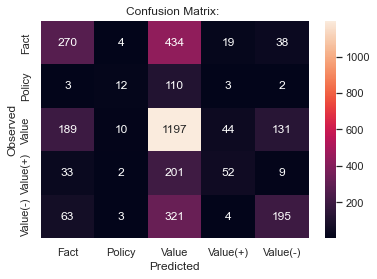

In [20]:
evaluation(pred)

### Trying cross validation

In [21]:
X= bagOfWords(corpusA)
y=dfA['label']
scores = cross_validate(clf, X, y, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], return_train_score=True)

labels=["", "Fact", "Policy", "Value","Value(+)","Value(-)"];

#TODO make visualization pretty uwu

### Helper function to perform Best Parameters Search

In [22]:
## parameter_grid = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': range(10, 20), 'max_features': range(10,20)} exemplo de grid

def bestParameterSearch( clf, parameter_grid):
    grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=10, verbose=4, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    print('Best estimator: {}'.format(grid_search.best_estimator_))
    return grid_search

#TODO flavia
#### Other classifiers

Try out using other classifiers, such as:
- *Logistic Regression*, through scikit-learn's [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class.
- *Decision Tree*, through scikit-learn's [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class. This model always assigns a probability of 1 to one of the classes.
- *Random Forest*, through scikit-learn's [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class.
- *Support Vector Machines (SVM)*, through scikit-learn's [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) class. The SVM model also allows you to get probabilities, but for that you need to use the *probability=True* parameter setting in its constructor.
- *Perceptron*, through scikit-learn's [Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) class. This model does not allow you to get probabilities.
- *eXtreme Gradient Boosting*, through [XGBoost](https://xgboost.readthedocs.io/en/stable/).

## Improving from our baseline

Now that we've established our starting point, we'll be trying different pre-processing techniques, different classifiers and other ideas to try to improve our results as much as possible

### Preprocessing techniques




### Ambiguous dataset
As we saw on our brief data analysis, there are a considerable number of ADUs that were found by multiple annotators, but different labels were assigned to them. When feeding our classifiers this ambiguous data, it will make it harder for them to achieve good results. Having this in mind, we decided to try to remove this ambiguity in hopes of having better results. from the dataset every token which was labelled differently by annotators.  We implemented this by listing every token which had multiple labels assigned. Then we removed it following this logic:
- if it was only found by 2 or 3 annotators and they all disagree on the label, then all the entries of that token are removed
- if it is found by 3 annotators and 2 of them agree, then only the different one is removed. 

This procedure ends up removing about 3000 lines from our original dataset, which is a significant ammount.

In [23]:
def dropAmbiguousADUs(df):
    aux=df[df.duplicated(['ranges', 'article_id'], keep=False)].sort_values(by=['article_id','ranges'])
    aux=aux.drop_duplicates(subset=['article_id','ranges','label'],keep=False).sort_values(by=['article_id', 'ranges'])
    aux.index.name = 'id'
    tabuIndexes=aux.index.values
    cleandf=df.drop(tabuIndexes)
    return cleandf


Let's try it!

(13728, 9000)
(13728,)
Report:
              precision    recall  f1-score   support

        Fact       0.61      0.43      0.51       600
      Policy       0.68      0.12      0.21       106
       Value       0.59      0.85      0.70      1346
    Value(+)       0.56      0.18      0.27       237
    Value(-)       0.59      0.40      0.47       457

    accuracy                           0.60      2746
   macro avg       0.61      0.40      0.43      2746
weighted avg       0.60      0.60      0.56      2746


AUC Score:
{'Value(+)': 0.5839416917661818, 'Value': 0.6434483124601995, 'Policy': 0.5601843910806176, 'Value(-)': 0.6711649187007024, 'Fact': 0.677255358807083}



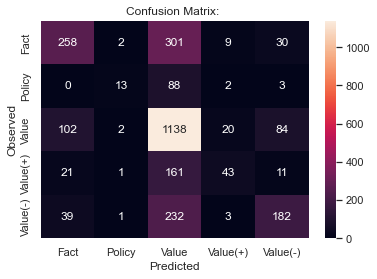

In [26]:
cleandf=dropAmbiguousADUs(df)
corpusClean= buildCorpus(cleandf)
X_train, X_test, y_train, y_test= split(corpusClean, cleandf)
clf = MultinomialNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

### Let's try using a lemmatizer!
Stemming just removes or stems the last few characters of a word, often leading to incorrect meanings and spelling. Lemmatization considers the context and converts the word to its meaningful base form, making it more accurate. 
As the dataset is in portuguese, we had to find lemmatizers outside of the NLTK library. We found NLPyPort, a library that provides Lemmatization for portuguese developed by researchers at University of Coimbra. The lemmatizer works really well but unfortunately it's very slow, so it was impossible to test in a large enough portion to train and sucessfully test our dataset.

In [23]:
def buildCorpusLemma(df):
    df=df[['tokens', 'label']]
    corpus = []
    options = {
			"tokenizer" : True,
			"pos_tagger" : False,
			"lemmatizer" : True,
			"entity_recognition" : False,
			"np_chunking" : False,
			"pre_load" : False,
			"string_or_array" : True
    }
  
    for i in df.itertuples():
        # get token and remove non alpha chars
        token= unidecode.unidecode(i.tokens)
        token = re.sub('[^a-zA-Z]', ' ', token)
        # to lower-case
        token =  token.lower()
        # split into tokens, apply stemming and remove stop words
        token = ' '.join([w for w in new_full_pipe(token,options=options).lemas if not w in set(stopwords.words('portuguese'))])
        corpus.append(token)
    return corpus

Let's try using it on only two rows

In [24]:

# get the start time
st = time.time()
corpusLemma=buildCorpusLemma(dfA[0:1])
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

{'tokenizer': True, 'pos_tagger': False, 'lemmatizer': True, 'entity_recognition': False, 'np_chunking': False, 'pre_load': False, 'string_or_array': True}
Execution time: 19.850761890411377 seconds


In [25]:
print(corpusLemma)

['facto nao apenas fruto ignorancia EOS']


In [26]:

st = time.time()
corpusStem=buildCorpus(dfA[0:1])
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')
print(corpusStem)

Execution time: 0.01400303840637207 seconds
['fact nao apen frut ignoranc']


As we can see, this Lemmatizer takes a way bigger ammount of time to process the same text that the SnowballStemmer, so it's not viable to use.

### Trying different stemmers

(16743, 8733)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.47      0.33      0.39       765
      Policy       0.40      0.09      0.15       130
       Value       0.52      0.75      0.61      1571
    Value(+)       0.34      0.15      0.21       297
    Value(-)       0.51      0.32      0.40       586

    accuracy                           0.50      3349
   macro avg       0.45      0.33      0.35      3349
weighted avg       0.49      0.50      0.47      3349


AUC Score:
{'Value(-)': 0.6288189001666339, 'Value': 0.5673454965169457, 'Policy': 0.5433579468062227, 'Value(+)': 0.56134079987291, 'Fact': 0.6114465084279326}



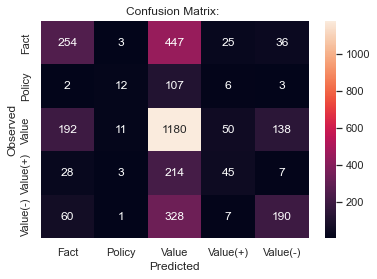

In [27]:
corpusRSLP= buildCorpus(df, RSLPStemmer())
X_train, X_test, y_train, y_test= split (corpusRSLP, df)
clf = MultinomialNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

### SpaCy pre-processing (with lemmatization)
After some research, we were able to find a portuguese language model in spaCy that can be used to process our dataset and lemmatize it

In [27]:
lm = spacy.load('pt_core_news_md')

def buildCorpusSpaCy(df):
    df=df[['tokens', 'label']]
    corpus = []
    for i in df.itertuples():
        # get token and remove non alpha chars
        token= unidecode.unidecode(i.tokens)
        token = re.sub('[^a-zA-Z]', ' ', token)
        # to lower-case
        token =  token.lower()
        # split into tokens, apply lemmatization and remove stop words
        token = ' '.join([w.lemma_ for w in lm(token) if not w in set(stopwords.words('portuguese'))])
        corpus.append(token)
    return corpus

(13728, 10944)
(13728,)
Report:
              precision    recall  f1-score   support

        Fact       0.63      0.45      0.52       600
      Policy       0.89      0.08      0.14       106
       Value       0.59      0.86      0.70      1346
    Value(+)       0.58      0.16      0.25       237
    Value(-)       0.61      0.39      0.48       457

    accuracy                           0.60      2746
   macro avg       0.66      0.38      0.42      2746
weighted avg       0.61      0.60      0.56      2746


AUC Score:
{'Value(+)': 0.5726784419969965, 'Value': 0.6429776056039057, 'Policy': 0.5375464551172098, 'Value(-)': 0.6702835270578631, 'Fact': 0.6852213420316869}



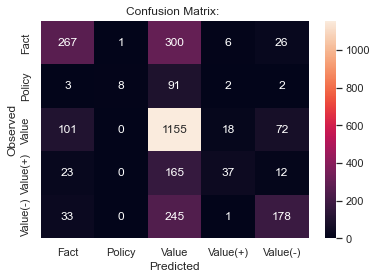

In [28]:
corpusSpacy= buildCorpusSpaCy(cleandf)
X_train, X_test, y_train, y_test= split(corpusSpacy, cleandf)
clf = MultinomialNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

In [30]:
corpusSpacyA= buildCorpusSpaCy(dfA)
corpusSpacyB= buildCorpusSpaCy(dfB)
corpusSpacyC= buildCorpusSpaCy(dfC)
corpusSpacyD= buildCorpusSpaCy(dfD)

Unfortunately the results are still slightly worst than our baseline

### Stanza Preprocessing

In [31]:
stanza.download('pt', verbose=False)

In [32]:
pt_nlp = stanza.Pipeline('pt',processors='tokenize,lemma,pos,depparse', verbose=False)

def buildCorpusStanza(df):
    df=df[['tokens', 'label']]
    corpus = []
    for i in df.itertuples():
        # get token and remove non alpha chars
        token= unidecode.unidecode(i.tokens)
        token = re.sub('[^a-zA-Z]', ' ', token)
        # to lower-case
        token =  token.lower()
        # split into tokens, apply lemmatization and remove stop words
        token = ' '.join([w.lemma for i,s in enumerate(pt_nlp(token).sentences) for w in s.words if not w in set(stopwords.words('portuguese'))])
        corpus.append(token)
    return corpus

(16743, 11156)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.48      0.36      0.41       765
      Policy       0.37      0.05      0.09       130
       Value       0.52      0.77      0.62      1571
    Value(+)       0.48      0.15      0.23       297
    Value(-)       0.50      0.30      0.38       586

    accuracy                           0.51      3349
   macro avg       0.47      0.33      0.35      3349
weighted avg       0.50      0.51      0.48      3349


AUC Score:
{'Value(-)': 0.6195363772127788, 'Value': 0.5744215136697983, 'Policy': 0.5250591440246613, 'Value(+)': 0.567730052821796, 'Fact': 0.6235294117647059}



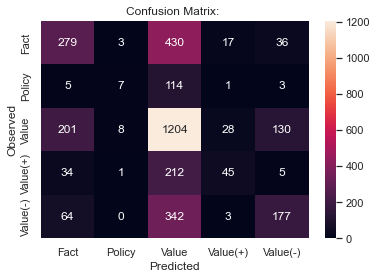

In [33]:
corpusStanza= buildCorpusStanza(df)
X_train, X_test, y_train, y_test= split(corpusStanza, df)
clf = MultinomialNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

### Dealing with an imbalanced dataset

As we saw from our brief data analysis, the dataset has an imbalanced destribution among the classes, so now we will try to deal with this using sampling techniques.

#### Undersampling

Since this is an NLP task and we have a significant ammount of data to use, we think that using undersampling techniques would be more helpful than oversampling.

#### Random Undersampling
Under-sample the majority class(es) by randomly picking samples with or without replacement.

In [34]:
def split_randomUnderSampling(corpus, df):
    X=bagOfWords(corpus)
    y=df['label']
    print('Original dataset shape %s' % Counter(y))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)
    rus = RandomUnderSampler(sampling_strategy={'Value': 2500, 'Fact': 2500,'Value(-)': 2000}, random_state=1)
    rus.fit(X_train, y_train)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_resampled))
    return  X_resampled, X_test, y_resampled, y_test

Original dataset shape Counter({'Value': 8102, 'Fact': 3663, 'Value(-)': 2900, 'Value(+)': 1411, 'Policy': 667})
Resampled dataset shape Counter({'Fact': 2500, 'Value': 2500, 'Value(-)': 2000, 'Value(+)': 1114, 'Policy': 537})
Report:
              precision    recall  f1-score   support

        Fact       0.40      0.53      0.46       765
      Policy       0.44      0.17      0.24       130
       Value       0.58      0.52      0.55      1571
    Value(+)       0.40      0.31      0.35       297
    Value(-)       0.43      0.49      0.46       586

    accuracy                           0.48      3349
   macro avg       0.45      0.40      0.41      3349
weighted avg       0.49      0.48      0.48      3349


AUC Score:
{'Value(-)': 0.6751320780820175, 'Value': 0.5965066349519805, 'Policy': 0.5802662078524148, 'Value(+)': 0.6310820083755864, 'Fact': 0.6477597179222566}



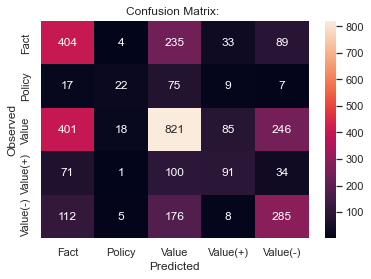

In [35]:
X_train, X_test, y_train, y_test= split_randomUnderSampling(corpus, df)
clf = MultinomialNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

#### NearMiss UnderSampling
Near Miss refers to a collection of undersampling methods that select examples based on the distance of majority class examples to minority class examples.

In [36]:
def split_NearMissUnderSampling(corpus, df):
    X=bagOfWords(corpus)
    y=df['label']
    print('Original dataset shape %s' % Counter(y))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)
    us = NearMiss(version=1)
    us.fit(X_train, y_train)
    X_resampled, y_resampled = us.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_resampled))
    return  X_resampled, X_test, y_resampled, y_test

Original dataset shape Counter({'Value': 8102, 'Fact': 3663, 'Value(-)': 2900, 'Value(+)': 1411, 'Policy': 667})
Resampled dataset shape Counter({'Fact': 537, 'Policy': 537, 'Value': 537, 'Value(+)': 537, 'Value(-)': 537})
Report:
              precision    recall  f1-score   support

        Fact       0.39      0.15      0.21       765
      Policy       0.06      0.92      0.11       130
       Value       0.57      0.07      0.13      1571
    Value(+)       0.18      0.29      0.22       297
    Value(-)       0.38      0.18      0.25       586

    accuracy                           0.16      3349
   macro avg       0.32      0.32      0.18      3349
weighted avg       0.44      0.16      0.18      3349


AUC Score:
{'Value(-)': 0.5608436197979394, 'Value': 0.51241641421175, 'Policy': 0.6509200181613974, 'Value(+)': 0.5778944976192683, 'Fact': 0.5387598899208805}



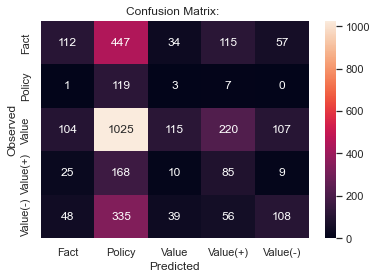

In [37]:
X_train, X_test, y_train, y_test= split_NearMissUnderSampling(corpus, df)
clf = MultinomialNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

#### Condensed Nearest Neighbor Rule Undersampling
Condensed Nearest Neighbors, or CNN for short, is an undersampling technique that seeks a subset of a collection of samples that results in no loss in model performance, referred to as a minimal consistent set.

In [38]:
def split_CNNUnderSampling(corpus, df):
    X=bagOfWords(corpus)
    y=df['label']
    print('Original dataset shape %s' % Counter(y))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)
    us = CondensedNearestNeighbour(n_neighbors=3)
    us.fit(X_train, y_train)
    X_resampled, y_resampled = us.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_resampled))
    return  X_resampled, X_test, y_resampled, y_test

In [39]:
# X_train, X_test, y_train, y_test= split_CNNUnderSampling(corpus, df)
# clf = MultinomialNB()
# clf.fit(X_train, y_train)
# pred = clf.predict(X_test)
# evaluation(pred)

### Oversampling

#### SMOTE
Statistical technique for increasing the number of cases in your dataset in a balanced way. The component works by generating new instances from existing minority cases that you supply as input.


In [40]:
def split_SMOTE(corpus, df):
    X=bagOfWords(corpus)
    y=df['label']
    print('Original dataset shape %s' % Counter(y))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)
    #smote = SMOTE(sampling_strategy={'Value(-)': 3000, 'Value(+)': 2000, 'Policy': 1000}, random_state=0)
    smote = SMOTE(sampling_strategy='all', random_state=0)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_resampled))
    return  X_resampled, X_test, y_resampled, y_test

Original dataset shape Counter({'Value': 8102, 'Fact': 3663, 'Value(-)': 2900, 'Value(+)': 1411, 'Policy': 667})
Resampled dataset shape Counter({'Value': 6531, 'Fact': 6531, 'Value(-)': 6531, 'Value(+)': 6531, 'Policy': 6531})
Report:
              precision    recall  f1-score   support

        Fact       0.44      0.45      0.44       765
      Policy       0.24      0.38      0.30       130
       Value       0.58      0.49      0.53      1571
    Value(+)       0.30      0.41      0.35       297
    Value(-)       0.45      0.50      0.48       586

    accuracy                           0.47      3349
   macro avg       0.40      0.45      0.42      3349
weighted avg       0.49      0.47      0.48      3349


AUC Score:
{'Value(-)': 0.6872837557237953, 'Value': 0.5887702730665987, 'Policy': 0.6648517217482734, 'Value(+)': 0.6607076664416114, 'Fact': 0.6391640866873065}



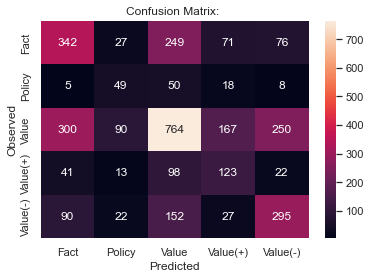

In [41]:
X_train, X_test, y_train, y_test= split_SMOTE(corpus, df)
clf = MultinomialNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

## Trying different classifiers 

### Logistic Regression

Different solver-penalty combinations will be experimented with, being that only solvers able to handle multiclass problems will be used, as only these will be able to handle muntinomial loss. It is clear that when penalty='none' is used, the results will be worse, but nonetheless and for comparison effect, these results will be shown as well.

#### Solver Saga

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.45      0.30      0.36       765
      Policy       0.50      0.29      0.37       130
       Value       0.52      0.74      0.61      1571
    Value(+)       0.42      0.20      0.27       297
    Value(-)       0.49      0.30      0.38       586

    accuracy                           0.50      3349
   macro avg       0.47      0.37      0.40      3349
weighted avg       0.49      0.50      0.47      3349


AUC Score:
{'Value(-)': 0.6182696381610234, 'Value': 0.5642587563250965, 'Policy': 0.6402513919755299, 'Value(+)': 0.5843731107492576, 'Fact': 0.5957129342965257}



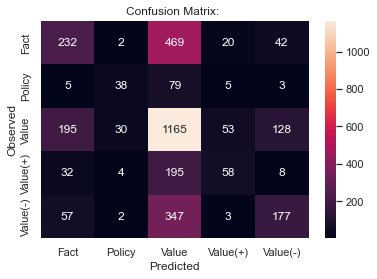

In [42]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = LogisticRegression(solver="saga", penalty="l1")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.45      0.34      0.39       765
      Policy       0.56      0.37      0.45       130
       Value       0.53      0.70      0.60      1571
    Value(+)       0.41      0.25      0.31       297
    Value(-)       0.47      0.35      0.40       586

    accuracy                           0.50      3349
   macro avg       0.48      0.40      0.43      3349
weighted avg       0.49      0.50      0.48      3349


AUC Score:
{'Value(-)': 0.6329828956258902, 'Value': 0.5736460695436622, 'Policy': 0.6788682581786031, 'Value(+)': 0.6053661340358588, 'Fact': 0.6083548331613348}



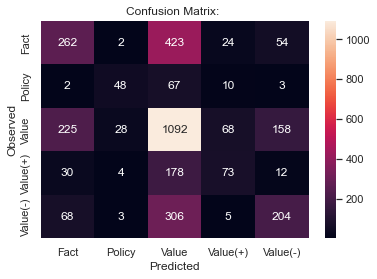

In [43]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = LogisticRegression(solver="saga", penalty="l2")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.45      0.32      0.37       765
      Policy       0.55      0.32      0.41       130
       Value       0.52      0.73      0.61      1571
    Value(+)       0.40      0.21      0.27       297
    Value(-)       0.51      0.33      0.40       586

    accuracy                           0.50      3349
   macro avg       0.49      0.38      0.41      3349
weighted avg       0.49      0.50      0.48      3349


AUC Score:
{'Value(-)': 0.631197664407412, 'Value': 0.5715028579734345, 'Policy': 0.6561019905847492, 'Value(+)': 0.5879491728115581, 'Fact': 0.6011136910904712}



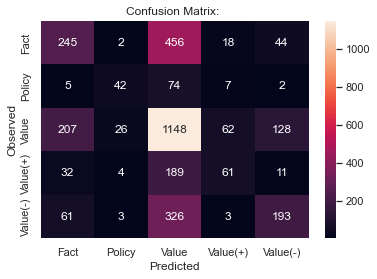

In [44]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = LogisticRegression(solver="saga", penalty="elasticnet", l1_ratio=0.5) #TODO: find better l1_ratio
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.42      0.37      0.39       765
      Policy       0.56      0.45      0.50       130
       Value       0.54      0.62      0.58      1571
    Value(+)       0.41      0.34      0.37       297
    Value(-)       0.46      0.41      0.44       586

    accuracy                           0.49      3349
   macro avg       0.48      0.44      0.46      3349
weighted avg       0.49      0.49      0.49      3349


AUC Score:
{'Value(-)': 0.6546514830914114, 'Value': 0.577317793900842, 'Policy': 0.7196226730709488, 'Value(+)': 0.6457872742276412, 'Fact': 0.6094556243550051}



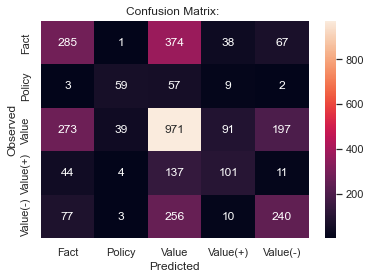

In [45]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = LogisticRegression(solver="saga", penalty="none")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

### Solver lbfgs

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.44      0.34      0.39       765
      Policy       0.56      0.37      0.45       130
       Value       0.53      0.69      0.60      1571
    Value(+)       0.40      0.25      0.30       297
    Value(-)       0.47      0.35      0.40       586

    accuracy                           0.50      3349
   macro avg       0.48      0.40      0.43      3349
weighted avg       0.49      0.50      0.48      3349


AUC Score:
{'Value(-)': 0.6338361379467092, 'Value': 0.5729724785356636, 'Policy': 0.6788682581786031, 'Value(+)': 0.60503848003848, 'Fact': 0.6073142414860682}



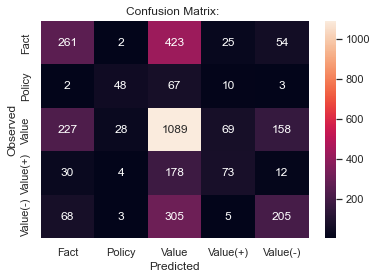

In [46]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = LogisticRegression(solver="lbfgs", penalty="l2")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)


(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.40      0.40      0.40       765
      Policy       0.51      0.45      0.48       130
       Value       0.54      0.57      0.56      1571
    Value(+)       0.35      0.34      0.35       297
    Value(-)       0.46      0.43      0.44       586

    accuracy                           0.48      3349
   macro avg       0.45      0.44      0.45      3349
weighted avg       0.48      0.48      0.48      3349


AUC Score:
{'Value(-)': 0.660960782351873, 'Value': 0.5730956330967858, 'Policy': 0.714533897292518, 'Value(+)': 0.6407538689648782, 'Fact': 0.6120055039559683}



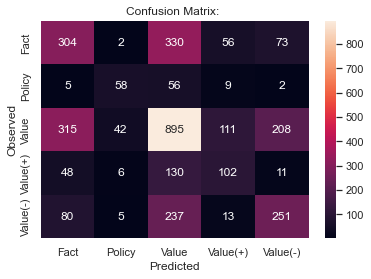

In [47]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = LogisticRegression(solver="lbfgs", penalty="none")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)


### Solver Sag

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.45      0.34      0.39       765
      Policy       0.56      0.37      0.45       130
       Value       0.53      0.69      0.60      1571
    Value(+)       0.40      0.25      0.31       297
    Value(-)       0.47      0.35      0.40       586

    accuracy                           0.50      3349
   macro avg       0.48      0.40      0.43      3349
weighted avg       0.49      0.50      0.49      3349


AUC Score:
{'Value(-)': 0.6345084175458491, 'Value': 0.5735719620025218, 'Policy': 0.6788682581786031, 'Value(+)': 0.6052023070371694, 'Fact': 0.6083548331613348}



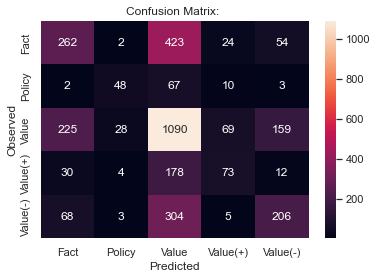

In [48]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = LogisticRegression(solver="sag", penalty="l2")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)


(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.41      0.38      0.40       765
      Policy       0.56      0.45      0.50       130
       Value       0.54      0.60      0.57      1571
    Value(+)       0.39      0.35      0.37       297
    Value(-)       0.46      0.43      0.44       586

    accuracy                           0.49      3349
   macro avg       0.47      0.44      0.46      3349
weighted avg       0.49      0.49      0.49      3349


AUC Score:
{'Value(-)': 0.6608313909177712, 'Value': 0.5764132880907391, 'Policy': 0.7159318469663297, 'Value(+)': 0.6499000489826179, 'Fact': 0.6098942208462332}



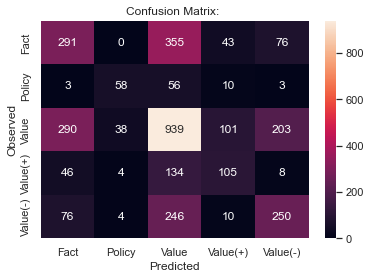

In [49]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = LogisticRegression(solver="sag", penalty="none")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

### Solver newton-cg

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.45      0.34      0.39       765
      Policy       0.56      0.37      0.45       130
       Value       0.53      0.69      0.60      1571
    Value(+)       0.40      0.25      0.31       297
    Value(-)       0.47      0.35      0.40       586

    accuracy                           0.50      3349
   macro avg       0.48      0.40      0.43      3349
weighted avg       0.49      0.50      0.49      3349


AUC Score:
{'Value(-)': 0.6338361379467092, 'Value': 0.573609015773092, 'Policy': 0.6788682581786031, 'Value(+)': 0.6052023070371694, 'Fact': 0.6083548331613348}



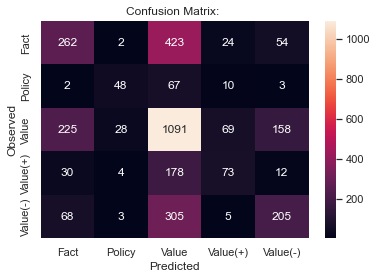

In [50]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = LogisticRegression(solver="newton-cg", penalty="l2")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)


(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.37      0.38      0.38       765
      Policy       0.36      0.42      0.39       130
       Value       0.56      0.51      0.53      1571
    Value(+)       0.29      0.34      0.31       297
    Value(-)       0.42      0.46      0.44       586

    accuracy                           0.45      3349
   macro avg       0.40      0.42      0.41      3349
weighted avg       0.46      0.45      0.46      3349


AUC Score:
{'Value(-)': 0.6639621077648448, 'Value': 0.576154627711638, 'Policy': 0.6929361722465172, 'Value(+)': 0.6280487266725798, 'Fact': 0.5955022359821123}



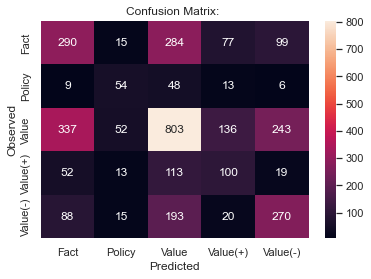

In [51]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = LogisticRegression(solver="newton-cg", penalty="none")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

## Decision Tree

TODO: fix smh


In this section, we will explore different criterion offered by SKTLearn Decision Tree Classifier together with different tree max depths: none, 50, 25.

### Criterion Gini

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.39      0.42      0.41       765
      Policy       0.44      0.48      0.46       130
       Value       0.54      0.56      0.55      1571
    Value(+)       0.35      0.31      0.33       297
    Value(-)       0.46      0.38      0.41       586

    accuracy                           0.47      3349
   macro avg       0.44      0.43      0.43      3349
weighted avg       0.47      0.47      0.47      3349


AUC Score:
{'Value(-)': 0.6410249283869365, 'Value': 0.5730433640097979, 'Policy': 0.7260353191387675, 'Value(+)': 0.6265400841088914, 'Fact': 0.6128869969040248}



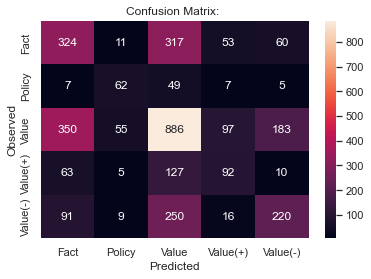

In [52]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = DecisionTreeClassifier(criterion="gini", max_depth=None, max_features="auto")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.41      0.04      0.07       765
      Policy       0.27      0.03      0.06       130
       Value       0.47      0.96      0.64      1571
    Value(+)       0.42      0.03      0.05       297
    Value(-)       0.49      0.05      0.09       586

    accuracy                           0.47      3349
   macro avg       0.41      0.22      0.18      3349
weighted avg       0.45      0.47      0.34      3349


AUC Score:
{'Value(-)': 0.5199874252525141, 'Value': 0.510357334391126, 'Policy': 0.5136760102277343, 'Value(+)': 0.5116659164824303, 'Fact': 0.5110939112487101}



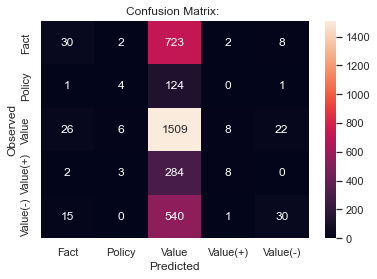

In [53]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = DecisionTreeClassifier(
    criterion="gini", max_depth=50, max_features="auto")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.53      0.03      0.06       765
      Policy       0.00      0.00      0.00       130
       Value       0.47      0.98      0.64      1571
    Value(+)       0.54      0.02      0.05       297
    Value(-)       0.78      0.05      0.10       586

    accuracy                           0.48      3349
   macro avg       0.46      0.22      0.17      3349
weighted avg       0.53      0.48      0.34      3349


AUC Score:
{'Value(-)': 0.5248218474502785, 'Value': 0.5113359477423692, 'Policy': 0.4996893445169307, 'Value(+)': 0.5108015497923755, 'Fact': 0.5116228070175438}



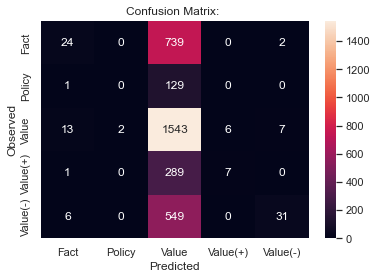

In [54]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = DecisionTreeClassifier(
    criterion="gini", max_depth=25, max_features="auto")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

### Criterion Entropy

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.39      0.44      0.41       765
      Policy       0.45      0.48      0.47       130
       Value       0.55      0.55      0.55      1571
    Value(+)       0.35      0.33      0.34       297
    Value(-)       0.44      0.35      0.39       586

    accuracy                           0.47      3349
   macro avg       0.43      0.43      0.43      3349
weighted avg       0.47      0.47      0.47      3349


AUC Score:
{'Value(-)': 0.6269595545228945, 'Value': 0.5727317185288185, 'Policy': 0.7303474562095251, 'Value(+)': 0.6338108035355742, 'Fact': 0.6170536635706915}



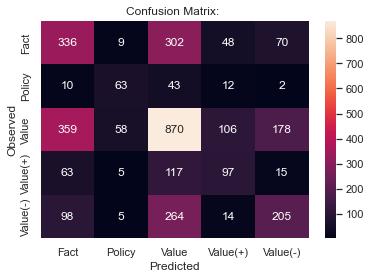

In [55]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = DecisionTreeClassifier(
    criterion="entropy", max_depth=None, max_features="auto")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.50      0.10      0.16       765
      Policy       0.49      0.23      0.31       130
       Value       0.48      0.93      0.63      1571
    Value(+)       0.44      0.05      0.09       297
    Value(-)       0.30      0.03      0.06       586

    accuracy                           0.48      3349
   macro avg       0.44      0.27      0.25      3349
weighted avg       0.45      0.48      0.36      3349


AUC Score:
{'Value(-)': 0.507757927464212, 'Value': 0.5219440663488039, 'Policy': 0.6105694553970418, 'Value(+)': 0.522139812277427, 'Fact': 0.5338536291709667}



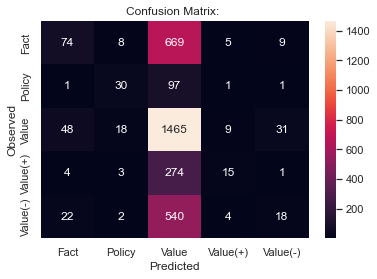

In [56]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = DecisionTreeClassifier(
    criterion="entropy", max_depth=50, max_features="auto")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.53      0.04      0.08       765
      Policy       0.29      0.04      0.07       130
       Value       0.47      0.98      0.64      1571
    Value(+)       0.17      0.00      0.01       297
    Value(-)       0.49      0.03      0.05       586

    accuracy                           0.47      3349
   macro avg       0.39      0.22      0.17      3349
weighted avg       0.45      0.47      0.33      3349


AUC Score:
{'Value(-)': 0.511247790463697, 'Value': 0.5101217654922352, 'Policy': 0.5173668363323536, 'Value(+)': 0.5008643666900547, 'Fact': 0.5148434812521501}



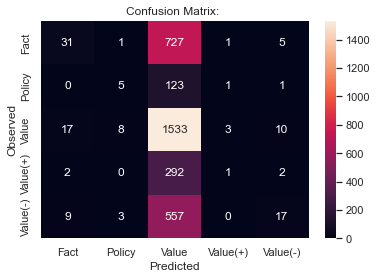

In [57]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = DecisionTreeClassifier(
    criterion="entropy", max_depth=25, max_features="auto")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

## Random Forest

#TODO: explore further better options

### Criterion Gini

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.44      0.36      0.39       765
      Policy       0.61      0.42      0.50       130
       Value       0.55      0.70      0.61      1571
    Value(+)       0.44      0.31      0.36       297
    Value(-)       0.52      0.38      0.44       586

    accuracy                           0.52      3349
   macro avg       0.51      0.43      0.46      3349
weighted avg       0.51      0.52      0.51      3349


AUC Score:
{'Value(-)': 0.6516501576784397, 'Value': 0.5941158612334502, 'Policy': 0.7024111644801301, 'Value(+)': 0.6338670673533059, 'Fact': 0.61109391124871}



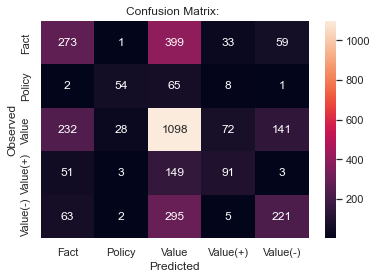

In [58]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = RandomForestClassifier(
    criterion="gini", max_depth=None, max_features="auto")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)


(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.68      0.05      0.09       765
      Policy       0.50      0.02      0.03       130
       Value       0.48      0.99      0.64      1571
    Value(+)       1.00      0.01      0.01       297
    Value(-)       0.54      0.03      0.05       586

    accuracy                           0.48      3349
   macro avg       0.64      0.22      0.16      3349
weighted avg       0.58      0.48      0.33      3349


AUC Score:
{'Value(-)': 0.5104461194304554, 'Value': 0.513075505918221, 'Policy': 0.5073816522092384, 'Value(+)': 0.5033670033670034, 'Fact': 0.5202399380804954}



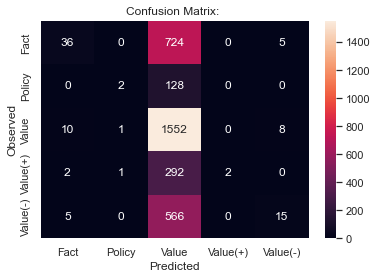

In [59]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = RandomForestClassifier(
    criterion="gini", max_depth=50, max_features="auto")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.50      0.01      0.02       765
      Policy       0.00      0.00      0.00       130
       Value       0.47      1.00      0.64      1571
    Value(+)       0.00      0.00      0.00       297
    Value(-)       1.00      0.00      0.00       586

    accuracy                           0.47      3349
   macro avg       0.39      0.20      0.13      3349
weighted avg       0.51      0.47      0.30      3349


AUC Score:
{'Value(-)': 0.5008532423208191, 'Value': 0.5018202888547271, 'Policy': 0.5, 'Value(+)': 0.5, 'Fact': 0.5032206742346061}



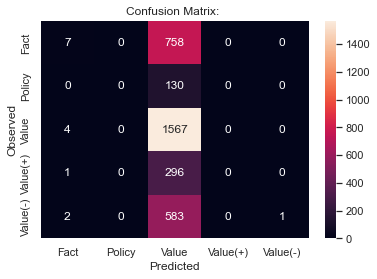

In [60]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = RandomForestClassifier(
    criterion="gini", max_depth=25, max_features="auto")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

### Criterion Entropy

(13728, 9000)
(13728,)
Report:
              precision    recall  f1-score   support

        Fact       0.62      0.44      0.51       600
      Policy       0.62      0.37      0.46       106
       Value       0.64      0.84      0.73      1346
    Value(+)       0.67      0.47      0.55       237
    Value(-)       0.70      0.50      0.58       457

    accuracy                           0.65      2746
   macro avg       0.65      0.52      0.57      2746
weighted avg       0.65      0.65      0.63      2746


AUC Score:
{'Value(+)': 0.7253263777825987, 'Value': 0.6948195712163022, 'Policy': 0.6794168096054889, 'Value(-)': 0.7271705703139265, 'Fact': 0.6805886921404163}



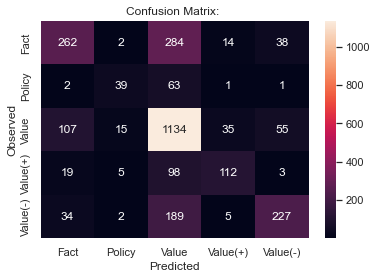

In [29]:
X_train, X_test, y_train, y_test = split(corpusClean, cleandf)
clf = RandomForestClassifier(
    criterion="entropy", max_depth=None, max_features="auto")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.66      0.05      0.10       765
      Policy       0.57      0.06      0.11       130
       Value       0.47      0.98      0.64      1571
    Value(+)       0.62      0.02      0.03       297
    Value(-)       0.43      0.02      0.04       586

    accuracy                           0.48      3349
   macro avg       0.55      0.23      0.18      3349
weighted avg       0.53      0.48      0.34      3349


AUC Score:
{'Value(-)': 0.50734350430296, 'Value': 0.5114318937376622, 'Policy': 0.5298372643200229, 'Value(+)': 0.5079260274214403, 'Fact': 0.5220803233574132}



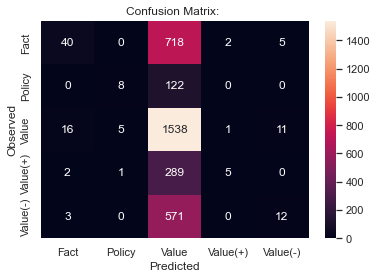

In [62]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = RandomForestClassifier(
    criterion="entropy", max_depth=50, max_features="auto")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.64      0.01      0.02       765
      Policy       0.00      0.00      0.00       130
       Value       0.47      1.00      0.64      1571
    Value(+)       0.00      0.00      0.00       297
    Value(-)       0.50      0.00      0.00       586

    accuracy                           0.47      3349
   macro avg       0.32      0.20      0.13      3349
weighted avg       0.45      0.47      0.31      3349


AUC Score:
{'Value(-)': 0.5006722795991397, 'Value': 0.502101503702871, 'Policy': 0.5, 'Value(+)': 0.5, 'Fact': 0.5049148606811146}



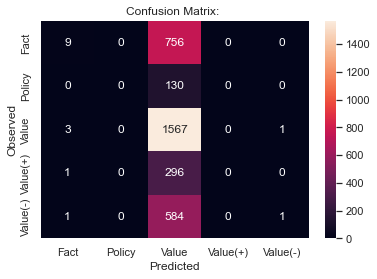

In [63]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = RandomForestClassifier(
    criterion="entropy", max_depth=25, max_features="auto")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

## SVM 



### Kernel Linear

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.42      0.35      0.38       765
      Policy       0.50      0.42      0.45       130
       Value       0.54      0.67      0.60      1571
    Value(+)       0.41      0.30      0.35       297
    Value(-)       0.48      0.36      0.41       586

    accuracy                           0.50      3349
   macro avg       0.47      0.42      0.44      3349
weighted avg       0.49      0.50      0.49      3349


AUC Score:
{'Value(-)': 0.6389040205840464, 'Value': 0.5816140622460384, 'Policy': 0.6993046096494374, 'Value(+)': 0.6305452956829103, 'Fact': 0.6045364637082904}



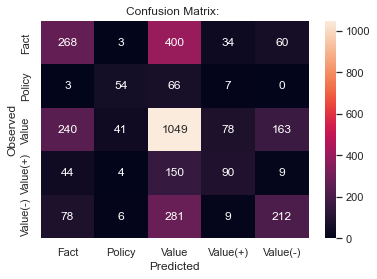

In [64]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=1.0, kernel="linear")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.45      0.32      0.37       765
      Policy       0.53      0.38      0.44       130
       Value       0.52      0.72      0.61      1571
    Value(+)       0.44      0.26      0.32       297
    Value(-)       0.48      0.31      0.37       586

    accuracy                           0.50      3349
   macro avg       0.48      0.40      0.42      3349
weighted avg       0.49      0.50      0.48      3349


AUC Score:
{'Value(-)': 0.6184252784540719, 'Value': 0.5709470514148812, 'Policy': 0.6816271178340143, 'Value(+)': 0.6123825630706364, 'Fact': 0.6018145854833161}



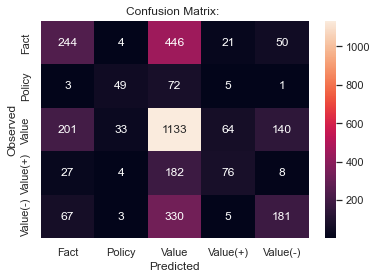

In [65]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=0.5, kernel="linear")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.49      0.28      0.36       765
      Policy       0.52      0.28      0.37       130
       Value       0.51      0.80      0.62      1571
    Value(+)       0.45      0.14      0.21       297
    Value(-)       0.51      0.25      0.34       586

    accuracy                           0.51      3349
   macro avg       0.50      0.35      0.38      3349
weighted avg       0.50      0.51      0.47      3349


AUC Score:
{'Value(-)': 0.5996005232478423, 'Value': 0.5611997617102445, 'Policy': 0.6370265490955145, 'Value(+)': 0.5621880667752228, 'Fact': 0.5973727210182318}



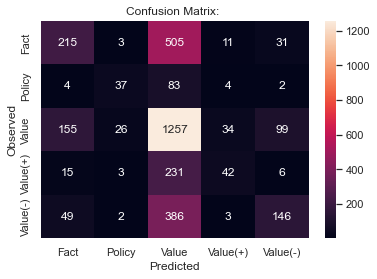

In [66]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=0.25, kernel="linear")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)


(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.52      0.22      0.31       765
      Policy       0.56      0.22      0.32       130
       Value       0.50      0.86      0.63      1571
    Value(+)       0.46      0.08      0.14       297
    Value(-)       0.52      0.18      0.27       586

    accuracy                           0.50      3349
   macro avg       0.51      0.31      0.33      3349
weighted avg       0.51      0.50      0.44      3349


AUC Score:
{'Value(-)': 0.5725283765605719, 'Value': 0.5484835162632042, 'Policy': 0.6079659234831649, 'Value(+)': 0.5358168844407377, 'Fact': 0.5800782593739251}



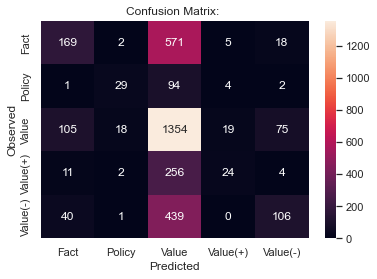

In [67]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=0.15, kernel="linear")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

### Kernel Poly

#### Gamma Scale

(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.46      0.10      0.16       765
      Policy       0.57      0.15      0.24       130
       Value       0.48      0.91      0.63      1571
    Value(+)       0.40      0.05      0.08       297
    Value(-)       0.47      0.09      0.15       586

    accuracy                           0.48      3349
   macro avg       0.48      0.26      0.25      3349
weighted avg       0.47      0.48      0.37      3349


AUC Score:
{'Value(-)': 0.5332004832260527, 'Value': 0.5135208671799539, 'Policy': 0.5745931608000573, 'Value(+)': 0.5201286565965465, 'Fact': 0.5317251461988305}



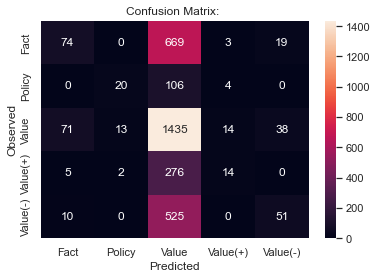

In [68]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=1.0, kernel="poly", degree=3, gamma="scale", coef0=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

In [ ]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=0.5, kernel="poly", degree=3, gamma="scale", coef0=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)


(16743, 9311)
(16743,)
Report:
              precision    recall  f1-score   support

        Fact       0.55      0.04      0.08       765
      Policy       0.60      0.09      0.16       130
       Value       0.47      0.97      0.64      1571
    Value(+)       0.43      0.01      0.02       297
    Value(-)       0.57      0.04      0.07       586

    accuracy                           0.48      3349
   macro avg       0.53      0.23      0.19      3349
weighted avg       0.51      0.48      0.34      3349


AUC Score:
{'Value(-)': 0.5165482071102909, 'Value': 0.5088116372468081, 'Policy': 0.5449112242215691, 'Value(+)': 0.5043951970557475, 'Fact': 0.5154239766081872}



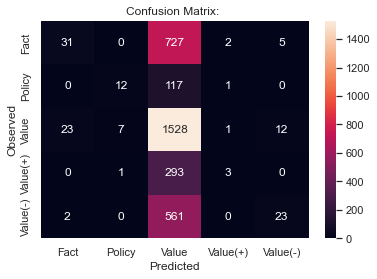

In [71]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=0.25, kernel="poly", degree=3, gamma="scale", coef0=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)


In [72]:
import dill

# save
dill.dump_session('notebook_env.db')


In [73]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=1.0, kernel="poly", degree=4, gamma="scale", coef0=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

(16743, 9311)
(16743,)


In [73]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=1.0, kernel="poly", degree=3, gamma="scale", coef0=2)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

(1, 5)
(16743,)


ValueError: Found input variables with inconsistent numbers of samples: [1, 16743]

#### Gamma Auto

In [74]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=1.0, kernel="poly", degree=3, gamma="auto", coef0=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)


(1, 5)
(16743,)


ValueError: Found input variables with inconsistent numbers of samples: [1, 16743]

In [75]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=0.5, kernel="poly", degree=3, gamma="auto", coef0=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)


(1, 5)
(16743,)


ValueError: Found input variables with inconsistent numbers of samples: [1, 16743]

In [76]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=0.25, kernel="poly", degree=3, gamma="auto", coef0=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

(1, 5)
(16743,)


ValueError: Found input variables with inconsistent numbers of samples: [1, 16743]

In [77]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=1.0, kernel="poly", degree=4, gamma="auto", coef0=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

(1, 5)
(16743,)


ValueError: Found input variables with inconsistent numbers of samples: [1, 16743]

In [78]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=1.0, kernel="poly", degree=3, gamma="auto", coef0=2)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

(1, 5)
(16743,)


ValueError: Found input variables with inconsistent numbers of samples: [1, 16743]

### Kernel RBF

#### Gamma Scale

In [79]:
X_train, X_test, y_train, y_test = split(corpusStanza, df)
clf = SVC(
    C=1.0, kernel="rbf", degree=3, gamma="scale", coef0=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

(16743, 11156)
(16743,)


Report:
              precision    recall  f1-score   support

        Fact       0.00      0.00      0.00       108
      Policy       0.00      0.00      0.00        14
       Value       0.66      1.00      0.80       443
    Value(+)       0.00      0.00      0.00        33
    Value(-)       0.00      0.00      0.00        69

    accuracy                           0.66       667
   macro avg       0.13      0.20      0.16       667
weighted avg       0.44      0.66      0.53       667




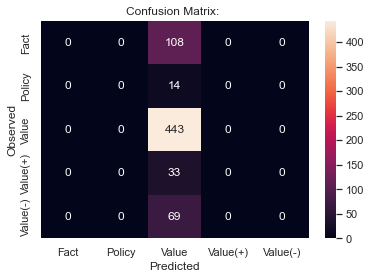

In [67]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=0.5, kernel="rbf", degree=3, gamma="scale", coef0=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)


Report:
              precision    recall  f1-score   support

        Fact       0.00      0.00      0.00       108
      Policy       0.00      0.00      0.00        14
       Value       0.66      1.00      0.80       443
    Value(+)       0.00      0.00      0.00        33
    Value(-)       0.00      0.00      0.00        69

    accuracy                           0.66       667
   macro avg       0.13      0.20      0.16       667
weighted avg       0.44      0.66      0.53       667




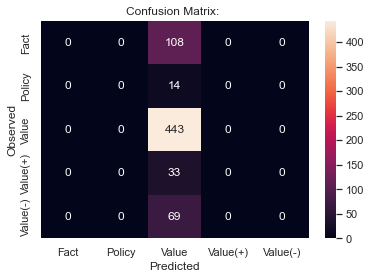

In [68]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=0.25, kernel="rbf", degree=3, gamma="scale", coef0=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)


Report:
              precision    recall  f1-score   support

        Fact       0.80      0.04      0.07       108
      Policy       0.00      0.00      0.00        14
       Value       0.67      1.00      0.80       443
    Value(+)       0.00      0.00      0.00        33
    Value(-)       0.00      0.00      0.00        69

    accuracy                           0.67       667
   macro avg       0.29      0.21      0.17       667
weighted avg       0.57      0.67      0.54       667




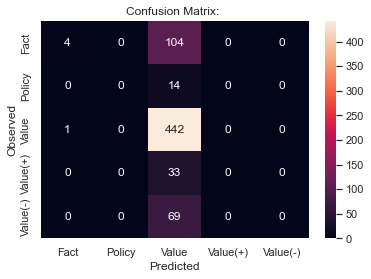

In [69]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=1.0, kernel="rbf", degree=4, gamma="scale", coef0=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)


Report:
              precision    recall  f1-score   support

        Fact       0.80      0.04      0.07       108
      Policy       0.00      0.00      0.00        14
       Value       0.67      1.00      0.80       443
    Value(+)       0.00      0.00      0.00        33
    Value(-)       0.00      0.00      0.00        69

    accuracy                           0.67       667
   macro avg       0.29      0.21      0.17       667
weighted avg       0.57      0.67      0.54       667




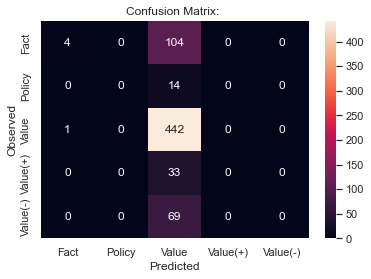

In [70]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=1.0, kernel="rbf", degree=3, gamma="scale", coef0=2)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

#### Gamma Auto

Report:
              precision    recall  f1-score   support

        Fact       0.00      0.00      0.00       108
      Policy       0.00      0.00      0.00        14
       Value       0.66      1.00      0.80       443
    Value(+)       0.00      0.00      0.00        33
    Value(-)       0.00      0.00      0.00        69

    accuracy                           0.66       667
   macro avg       0.13      0.20      0.16       667
weighted avg       0.44      0.66      0.53       667




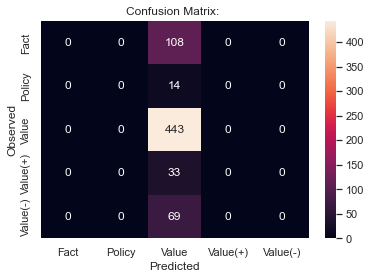

In [71]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=1.0, kernel="rbf", degree=3, gamma="auto", coef0=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

Report:
              precision    recall  f1-score   support

        Fact       0.00      0.00      0.00       108
      Policy       0.00      0.00      0.00        14
       Value       0.66      1.00      0.80       443
    Value(+)       0.00      0.00      0.00        33
    Value(-)       0.00      0.00      0.00        69

    accuracy                           0.66       667
   macro avg       0.13      0.20      0.16       667
weighted avg       0.44      0.66      0.53       667




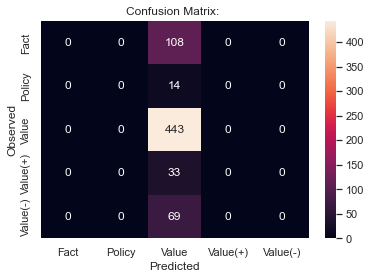

In [72]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=0.5, kernel="rbf", degree=3, gamma="auto", coef0=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

Report:
              precision    recall  f1-score   support

        Fact       0.00      0.00      0.00       108
      Policy       0.00      0.00      0.00        14
       Value       0.66      1.00      0.80       443
    Value(+)       0.00      0.00      0.00        33
    Value(-)       0.00      0.00      0.00        69

    accuracy                           0.66       667
   macro avg       0.13      0.20      0.16       667
weighted avg       0.44      0.66      0.53       667




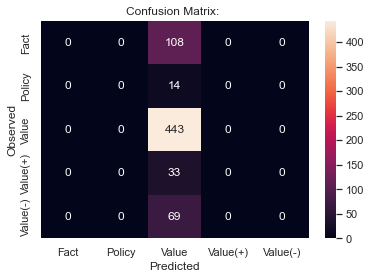

In [73]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=0.25, kernel="rbf", degree=3, gamma="auto", coef0=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

Report:
              precision    recall  f1-score   support

        Fact       0.00      0.00      0.00       108
      Policy       0.00      0.00      0.00        14
       Value       0.66      1.00      0.80       443
    Value(+)       0.00      0.00      0.00        33
    Value(-)       0.00      0.00      0.00        69

    accuracy                           0.66       667
   macro avg       0.13      0.20      0.16       667
weighted avg       0.44      0.66      0.53       667




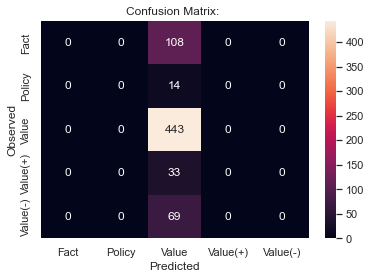

In [74]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=1.0, kernel="rbf", degree=4, gamma="auto", coef0=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

Report:
              precision    recall  f1-score   support

        Fact       0.00      0.00      0.00       108
      Policy       0.00      0.00      0.00        14
       Value       0.66      1.00      0.80       443
    Value(+)       0.00      0.00      0.00        33
    Value(-)       0.00      0.00      0.00        69

    accuracy                           0.66       667
   macro avg       0.13      0.20      0.16       667
weighted avg       0.44      0.66      0.53       667




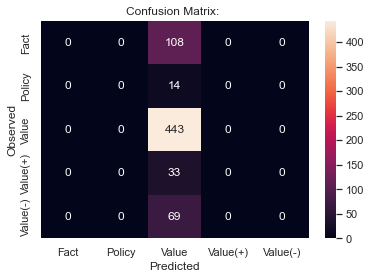

In [75]:
X_train, X_test, y_train, y_test = split(corpus, df)
clf = SVC(
    C=1.0, kernel="rbf", degree=3, gamma="auto", coef0=2)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
evaluation(pred)

### Kernel Sigmoid

### Kernel Precomputed